In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
# defining a parabolic function for Y values
def f(x):
  return 4*(x**2) + 2*x + 1

In [3]:
# creating a list of X values
x = np.arange(-10, 10, 0.5)
y = f(x)
print('\nvalues of x: ', x)
print('\nvalues of y: ', y)


values of x:  [-10.   -9.5  -9.   -8.5  -8.   -7.5  -7.   -6.5  -6.   -5.5  -5.   -4.5
  -4.   -3.5  -3.   -2.5  -2.   -1.5  -1.   -0.5   0.    0.5   1.    1.5
   2.    2.5   3.    3.5   4.    4.5   5.    5.5   6.    6.5   7.    7.5
   8.    8.5   9.    9.5]

values of y:  [381. 343. 307. 273. 241. 211. 183. 157. 133. 111.  91.  73.  57.  43.
  31.  21.  13.   7.   3.   1.   1.   3.   7.  13.  21.  31.  43.  57.
  73.  91. 111. 133. 157. 183. 211. 241. 273. 307. 343. 381.]


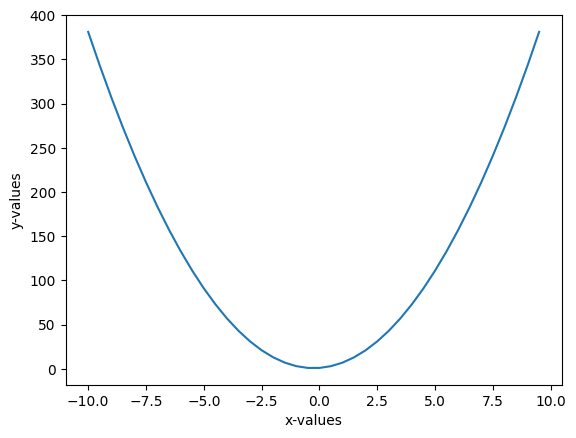

In [4]:
# plotting x and y values on a graph
plt.xlabel("x-values")
plt.ylabel("y-values")
plt.plot(x, y)

In [5]:
# derivative intuition, at a single pt x = 7.5
x = 7.5
# a small change in x which we will call h, here h is tending to 0 hence it is a very small value
h = 0.0000001
# calculating the value of y at x = 7.5, the original value
y_0 = f(x)
# calculating the value of y at x = 7.5 + h, the new value
y_1 = f(x+h)

# calculating the slope at that pt 
slope = (y_1 - y_0)/h
print('Slope at x = 7.5 is: ', slope)

Slope at x = 7.5 is:  62.00000058242949


In [6]:
# small change
h = 0.000001

# now trying this intuition for more complex functions
a = 2.3
b = -10.0
c = 5.5

# monitering slope when value of a changes a bit
da_0 = a*b + c
da_1 = (a+h)*b + c

print('da_0: ', da_0)
print('da_1: ', da_1)
print('Slope when a changes a bit: ', (da_1 - da_0)/h)

# monitering slope when value of b changes a bit
db_0 = a*b + c
db_1 = a*(b+h) + c

print('\ndb_0: ', db_0)
print('db_1: ', db_1)
print('Slope when b changes a bit: ', (db_1 - db_0)/h)

# monitering slope when value of c changes a bit
dc_0 = a*b + c
dc_1 = a*b + (c+h)

print('\ndc_0: ', dc_0)
print('dc_1: ', dc_1)
print('Slope when c changes a bit: ', (dc_1 - dc_0)/h)

da_0:  -17.5
da_1:  -17.50001
Slope when a changes a bit:  -9.999999999621423

db_0:  -17.5
db_1:  -17.4999977
Slope when b changes a bit:  2.2999999984563146

dc_0:  -17.5
dc_1:  -17.499999
Slope when c changes a bit:  1.0000000010279564


In [7]:
"""
now we will create a data structure in order to store the expressions for neural network
we need to keep track and keep pointers of what values produce what values hence the data structure is created accordingly
   
"""
class value:
    
    def __init__(self, data, _parents=(), _operation='', label=''):
        self.data = data
        self._prev = set(_parents)
        self._operation = _operation
        self.label = label
        self.gradient = 0.0
        
    def __repr__(self):
        return f'value(data = {self.data})'
    
    def __add__(self, other):
        sum = value(self.data + other.data, (self, other), '+')
        return sum
    
    def __mul__(self, other):
        product = value(self.data * other.data, (self, other), '*')
        return product

In [8]:
# testing the data structure
p = value(20.3, label='p')
q = value(10.0, label='q')
r = p * q; r.label = 'r'

print('The set values from which r was generated from: ', r._prev)
print('The opertaion from which r was genertaed: ', r._operation)
print('The value of r: ', r)

The set values from which r was generated from:  {value(data = 20.3), value(data = 10.0)}
The opertaion from which r was genertaed:  *
The value of r:  value(data = 203.0)


In [9]:
a = value(2.3, label='a')
b = value(-10.0, label='b')

c = a+b; c.label = 'c'
d = value(5.5, label='d')

e = c*d; e.label = 'e'
f = value(4.0, label='f')

g = e*f; g.label = 'g'

In [48]:
# now we need a way to visualize the data structure
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  # recursively builds the graph by looking at all the parents of each node
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for parent in v._prev:
        edges.add((parent, v))
        build(parent)
  build(root)
  return nodes, edges

def draw_graph(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  nodes, edges = trace(root)
  
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data: %.4f | grad: %.4f }" % (n.label, n.data, n.gradient), shape='record', style='filled', fillcolor='lightblue')
    # operation nodes are pseudo nodes, just expressed as nodes as node for connecting to actual nodes
    if n._operation:
      # if this value is a result of some operation, create an operation node for it
      dot.node(name = uid + n._operation, label = n._operation, shape='circle', style='filled', fillcolor='orange')
      # and connect this node to it
      dot.edge(uid + n._operation, uid, style='dashed', color='orange')

  for n1, n2 in edges:
    # connect n1 to the operation node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._operation, style='dashed', color='orange')

  return dot


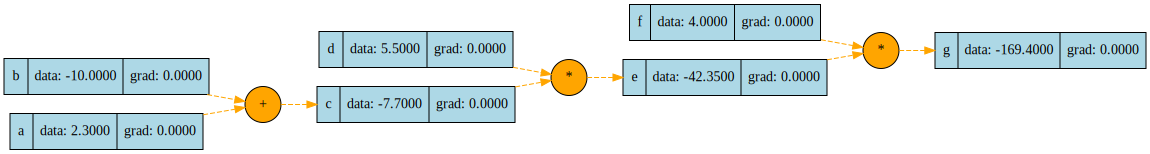

In [49]:
draw_graph(g)